# Task 1 - quantum coin

In [63]:
import qiskit as q
import numpy as np
import matplotlib.pyplot as plt

# initialize qubit

qubit = q.QuantumRegister(1, "qubit")
bit = q.ClassicalRegister(1, "bit")

# create circuit

circuit = q.QuantumCircuit(qubit, bit)
circuit.h(qubit)
circuit.measure(qubit, bit)
circuit.draw()

┌───┐┌─┐
qubit: ┤ H ├┤M├
       └───┘└╥┘
bit: 1/══════╩═
             0

In [64]:
# simulation

backend = q.Aer.get_backend("qasm_simulator")
job = q.execute(experiments = circuit, backend = backend, shots = 100)
res = job.result()
prob = res.get_counts(circuit)
print(prob)

{'0': 50, '1': 50}


# Task 2 - quantum prisoner dilemma

In [65]:
from scipy.linalg import expm
import numpy as np

# create custom gates

D = np.array([[0, 1], [-1, 0]])
Q = np.array([[1j, 0], [0, -1j]])

def J(gamma = 1):
    matrix = -1j*gamma * np.kron(D, D) / 2
    return q.extensions.UnitaryGate(expm(matrix), label = "J")

def J_dagger(gamma = 1):
    matrix = -1j*gamma * np.kron(D, D) / 2
    matrix = np.transpose(matrix)
    matrix = np.conjugate(matrix)
    return q.extensions.UnitaryGate(expm(matrix), label = "J_dagger")

gamma = 1
strategy_1 = D
strategy_2 = D

qubits = q.QuantumRegister(2, "qubit")
bits = q.ClassicalRegister(2, "bit")

circ = q.QuantumCircuit(qubits, bits)
circ.append(J(gamma), qubits)

gate_1 = q.extensions.UnitaryGate(np.kron(strategy_1, np.eye(2)), label = "1 decision")
circ.append(gate_1, qubits)

gate_2 = q.extensions.UnitaryGate(np.kron(np.eye(2), strategy_1), label = "2 decision")
circ.append(gate_2, qubits)

circ.append(J_dagger(gamma), qubits)
circ.measure(qubits, bits)
circ.draw()

┌────┐┌─────────────┐┌─────────────┐┌───────────┐┌─┐   
qubit_0: ┤0   ├┤0            ├┤0            ├┤0          ├┤M├───
         │  J ││  1 decision ││  2 decision ││  J_dagger │└╥┘┌─┐
qubit_1: ┤1   ├┤1            ├┤1            ├┤1          ├─╫─┤M├
         └────┘└─────────────┘└─────────────┘└───────────┘ ║ └╥┘
  bit: 2/══════════════════════════════════════════════════╩══╩═
                                                           0  1

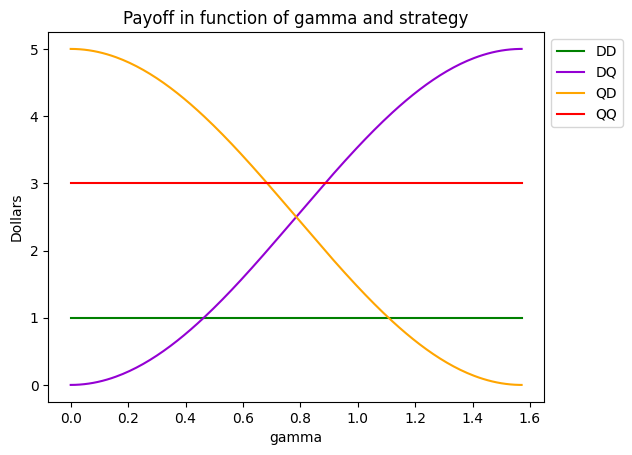

In [88]:
# build circuit

def experiment(gamma = 1, strategy_1 = D, strategy_2 = D):

    qubits = q.QuantumRegister(2, "qubit")
    bits = q.ClassicalRegister(2, "bit")

    circ = q.QuantumCircuit(qubits, bits)
    circ.append(J(gamma), qubits)
    gate = q.extensions.UnitaryGate(np.kron(strategy_1, strategy_2))
    circ.append(gate, qubits)
    circ.append(J_dagger(gamma), qubits)
    
    backend = q.Aer.get_backend("statevector_simulator")
    job = q.execute(circ, backend)
    res = job.result()
    psi = res.get_statevector()
    psi = np.asarray(psi)
    psi = psi.flatten()

    amplitudes = []
    for p in psi:
        amplitudes.append(p*np.conjugate(p))

    return np.real(np.array(amplitudes)) 

# pay offs

payoff = np.array([3, 0, 5, 1])

def money(gamma, strat_1, strat_2):
    return np.dot(payoff, experiment(gamma, strat_1, strat_2))

# simulation

gammas = np.linspace(0, np.pi/2, 200)

DD = []
for g in gammas:
    DD.append(money(g, D, D))

DQ = []
for g in gammas:
    DQ.append(money(g, D, Q))

QD = []
for g in gammas:
    QD.append(money(g, Q, D))

QQ = []
for g in gammas:
    QQ.append(money(g, Q, Q))

plt.plot(gammas, DD, color = "green")
plt.plot(gammas, QD, color = "darkviolet")
plt.plot(gammas, DQ, color = "orange")
plt.plot(gammas, QQ, color = "red")
plt.xlabel("gamma")
plt.ylabel("Dollars")
plt.title("Payoff in function of gamma and strategy")
plt.legend(["DD", "DQ", "QD", "QQ"], bbox_to_anchor = [1, 1])
plt.show()